# MA3315: Introduction to Visual Computing
## Assignment 1

##### Student Name: Ayush K. Rai

This assignment has two problems. 

Let us load the required libraries first. 

In [6]:
from __future__ import print_function
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter, convolve
import random
import sys
%matplotlib inline

## 1. The Canny edge detector 

For the first problem, we will implement our own Canny edge detector. Recall that the Canny edge detector consists of the following steps:
* Smoothing the image using a Gaussian filter
* Computing the gradient of the image&mdash;magnitude and direction&mdash;using the Sobel operator
* Non-maximum suppression using the gradient's magnitude and direction
* Double thresholding
* Edge connectivity using hysterisis

#### 1.A Smoothing

This standard smoothing operation can be implemented using the `gaussian_filter` function found in `sklearn.ndimage`. 
Alternatively, you can use the following Gaussian filter: 

`G = np.array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;`

#### 1.B Gradients

Use the Sobel operators to compute $g_x$ and $g_y$. The magnitude and direction of the gradient can be computed as 
$\sqrt{g_x^2 + g_y^2}$, and $\arctan\left(\frac{g_y}{g_x}\right)$

#### 1.C Non-maximum suppression

We will take a simplistic approach to non-maximum suppression. First, we quantise the gradient directions into four values&mdash;$0$, $\frac{\pi}{4}$, $\frac{\pi}{2}$, and $\frac{3\pi}{4}$. Next, we suppress gradients at all points that are not greater than the two neighbours found when moving in the direction perpendicular to the edge.

#### 1.D Doule thresholding

Double thresholding can be implemented by fixing two thresholds, `lo` and `hi`. Accordingly, we will have two *levels* of gradient magnitudes&mdash;*weak* and *strong*. Pixels where the magnitude of the gradient is greater than high will be designated *strong* points, while those where it lies between `lo` and `high` will be designated *weak*. 

#### 1.E Edge connectivity

Finally, we decide on edge connectivity as follows: 
* All pixels with strong gradients belong to edges, termed *definite edges*.
* All pixels with weak gradients belong to edges only if they are connected to definite edges. 

Given below is a template for the Canny edge detector. Your task is to complete this function, and write any supporting functions necessary. You are, of course, free to diverge from this template, if you so wish. 

In [205]:
def canny_edge_detector(img, thresh_lo, thresh_hi):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """    
    # Smooth the image first. 
    smoothed = gaussian_smoothing(img)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir_Quantized = gradient(smoothed)
        
    # Non-maximum suppression
    g_max = non_maximum_suppression(g_magnitude, g_dir_Quantized)
        
    # Double thresholding
    thresh_img, strongEdges  = double_thresholding(g_max,thresh_lo,thresh_hi)
    
    # Final edge connectivity
    edge_img  = connectivity(thresh_img,strongEdges)
    
    # Return the result
    return edge_img

def gaussian_smoothing(img):
    #Using Gaussian blur to reduce noise in the Image
    out_img = gaussian_filter(img,sigma=3)
    return out_img

def gradient(img):
    #Using Sobel Filters to get horizontal and vertical gradients of the Image
    sobel_horz_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobel_vert_filter = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    img_horz_grad = convolve(img,sobel_horz_filter) 
    img_vert_grad = convolve(img,sobel_vert_filter)
    
    grad_magnitude = np.power(np.power(img_horz_grad, 2.0) + np.power(img_vert_grad, 2.0), 0.5)
    grad_direction = np.arctan2(img_vert_grad, img_horz_grad)
    grad_direction_quantized = (np.round(grad_direction * (4.0 / np.pi))) % 4
    
    #print('--Grad Magnitude--')
    #print(grad_magnitude)
    
    #print('--Grad Direction--')
    #print(grad_direction)
    
    #print('--Grad Direction Quantized--')
    #print(np.min(grad_direction_quantized))
 
    return grad_magnitude, grad_direction_quantized

def non_maximum_suppression(g_magnitude,g_dir):
    g_suppressed = g_magnitude.copy()
    for row in range(g_magnitude.shape[0]):
        for col in range(g_magnitude.shape[1]):
            
            #Suppressing the pixel values at the image edge
            if row == 0 or row == g_magnitude.shape[0]-1 or col == 0 or col == g_magnitude.shape[1] - 1:
                g_suppressed[row, col] = 0
                continue
                
            tq = g_dir[row, col] #% 4
 
            if tq == 0: #0 if the gradient direction is 0 or 180 degrees
                if g_magnitude[row, col] <= g_magnitude[row, col-1] or g_magnitude[row, col] <= g_magnitude[row, col+1]:
                    g_suppressed[row, col] = 0
            if tq == 1: #1 if the gradient direction is 45 or 225 degrees 
                if g_magnitude[row, col] <= g_magnitude[row-1, col+1] or g_magnitude[row, col] <= g_magnitude[row+1, col-1]:
                    g_suppressed[row, col] = 0
            if tq == 2: #2 if the gradient direction is 90 or 270 degrees
                if g_magnitude[row, col] <= g_magnitude[row-1, col] or g_magnitude[row, col] <= g_magnitude[row+1, col]:
                    g_suppressed[row, col] = 0
            if tq == 3: #3 if the gradient direction is 135 or 315 degrees
                if g_magnitude[row, col] <= g_magnitude[row-1, col-1] or g_magnitude[row, col] <= g_magnitude[row+1, col+1]:
                    g_suppressed[row, col] = 0
                    
    return g_suppressed

def double_thresholding(g_suppressed,thresh_lo,thresh_hi):
    
    strong_edges = (g_suppressed > thresh_hi)
    
    #Strong Edges will have a value of 2, Weak Edges will have a value of 1
    thresholded_edges = np.array(strong_edges, dtype=np.uint8) + (g_suppressed > thresh_lo)
    
    return thresholded_edges, strong_edges

def connectivity(thresh_edges,strong_edges):
    '''
    Here we can apply connected component analysis.
    Refer to : https://en.wikipedia.org/wiki/Connected-component_labeling
    '''
    final_edges = strong_edges.copy()
    current_pixels = []
    for row in range(1, thresh_edges.shape[0]-1):
        for col in range(1, thresh_edges.shape[1]-1):
            #Checking whether the pixel belongs to the category of Weak Pixels
            if thresh_edges[row, col] != 1:
                continue
 
            #Get a patch of size
            local_patch = thresh_edges[row-1:row+2,col-1:col+2]
            patch_max = local_patch.max()
            if patch_max == 2:
                current_pixels.append((row, col))
                final_edges[row, col] = 1
 
    #Extending the strong edges based on current pixel values
    while len(current_pixels) > 0:
        new_pix = []
        for row, col in current_pixels:
            for x in range(-1, 2):
                for y in range(-1, 2):
                    if x == 0 and y == 0: continue
                    row_2 = row+x
                    col_2 = col+y
                    if thresh_edges[row_2, col_2] == 1 and final_edges[row_2, col_2] == 0:
                        new_pix.append((row_2, col_2))
                        final_edges[row_2, col_2] = 1
        current_pixels = new_pix
 
    return final_edges

Now test the code on a sample image&mdash;

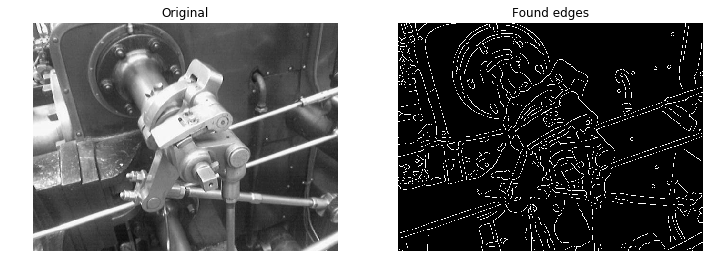

In [206]:
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

thresh_hi = 0.10
thresh_lo = 0.005

img = np.array(img, dtype=float)/np.max(img)


edges = canny_edge_detector(img,thresh_lo,thresh_hi)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(edges,cmap='gray')
plt.axis('off')
plt.title('Found edges')

plt.show()

### Comparing the Results with Opencv Inbuilt Canny Edge Detector

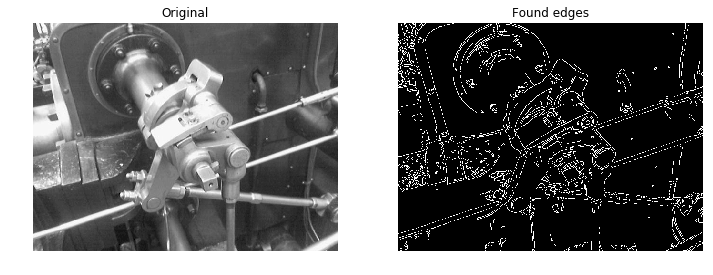

In [222]:
img = cv2.imread('valve.png',0)

edges = cv2.Canny(img,80,150)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(edges,cmap='gray')
plt.axis('off')
plt.title('Found edges')

plt.show()

## 2. Stitching two images

For this problem, you are given two images&mdash;`left.png` and `right.png`, which were extracted from a bigger image. All we know is that `left.png` lies to the left and a bit above of `right.png`, and there is an overlapping region between the two. Your task will be to *stitch* these images together so that you can form a bigger image out of two smaller images. 

Let us load the images first.

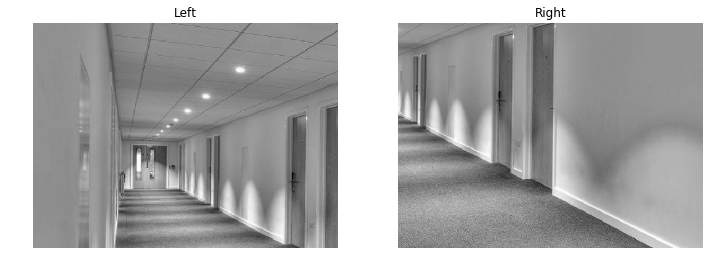

In [90]:
left_img   = cv2.imread('left.png')
left_img_gray   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('right.png')
right_img_gray  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img_gray, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img_gray, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

We will try to solve this problem using the Harris corner detector and the RANdom SAmple Consensus (RANSAC) algorithm. 

The steps are the following&mdash;
* Find corner points in both images using the Harris corner detector. 
* Choose a random pair of points&mdash;one from the left image, and the other from the right. 
* We will assume that this pair represents the same location in the scene in both images. This gives a translation vector, so the we can superimpose this point in the right image onto the left image.
* The translation gives us an overlapping region, which can be given a similarity score. 
* If we keep choosing this pair of points randomly, we can keep improving our similarity score until we have found the best match. 

Your task now is the complete the following code. 

In [357]:
def stitch_images(left, right, max_tries=10000):
    # Find corner points
    corners_left, img1  = harris_corner_detector(left)
    corners_right, img2 = harris_corner_detector(right)
    
    max_tries = min(len(corners_left),len(corners_right))
    
    plt.figure(figsize=(12,6))
    plt.imshow(img1, cmap='gray')
    plt.axis('off')
    plt.title('Harris Corners on Left Image')
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.imshow(img2, cmap='gray')
    plt.axis('off')
    plt.title('Harris Corners Right Image')
    plt.show()
    
    best_error = 255*left.shape[0]*left.shape[1]
    x_best_trans = None
    y_best_trans = None
    
    for n_try in range(max_tries):
        # Choose two points randomly
        c_left, c_right  = find_random_pair(corners_left, corners_right)
        
        if len(c_left)!=2 or len(c_right)!=2:
            continue
        
        # Get translation vector
        x_trans, y_trans = find_translation_vector(c_left, c_right)
        
        # Translate the right coordinate into left image
        c_right_translated = translate_point(c_right,x_trans,y_trans)
        
        #print('--c_right_translated--')
        #print(c_right_translated[0])
        #print(c_right_translated[1])
        
        #print('-Image Size-')
        #print(left_img_gray.shape[0])
        #print(left_img_gray.shape[1])
        
        #Check if the translated point is within Left Image Dimension
        if(c_right_translated[0] >= left_img_gray.shape[0] or c_right_translated[0] <= 0 or c_right_translated[1] >= left_img_gray.shape[1] or c_right_translated[1] <= 0 or c_left[0] >= left_img_gray.shape[0] or c_left[0] <= 0 or c_left[1] >= left_img_gray.shape[1] or c_left[1] <= 0):
            continue
    
                
        # Compute resulting error. 
        this_error = compute_error(left,c_left,c_right_translated)
        
        #print('Best Error')
        #print(best_error)
        
        #print('This error')
        #print(this_error)
        
        if this_error < best_error:
            best_error = this_error
            x_best_trans, y_best_trans = x_trans, y_trans
            
    # Get Homography Matrix
    print('--Best X Trans--')
    print(x_best_trans)
    
    print('--Best Y Trans--')
    print(y_best_trans)
    
    print('--Best Error--')
    print(best_error)
    
    homography_matrix = get_homography_matrix(x_best_trans,y_best_trans)
    
    #Perform Image Warping
    stitched_image = get_warp_image(homography_matrix,right)
    
    stitched_image[0:left.shape[0], 0:left.shape[1]] = left
    
    return stitched_image

def find_random_pair(corners_left,corners_right):
    
    left_corner_point = random.choice(corners_left)
    right_corner_point = random.choice(corners_right)
    
    if len(left_corner_point)!=3 or len(right_corner_point)!=3:
        return [],[]
    
    # Deleting the corner response
    del left_corner_point[-1]
    del right_corner_point[-1]
    
    return left_corner_point, right_corner_point
        
def find_translation_vector(left_corner_point,right_corner_point):
    '''This function finds the translation vector'''
    #print(left_corner_point)
    #print(right_corner_point)
    
    tx = left_corner_point[0] - right_corner_point[0]
    ty = left_corner_point[1] - right_corner_point[1]
    
    return tx,ty
    
def compute_error(left_img_gray,c_left,c_right_translated,window_size=2):
    '''Computing the Error of the overlapping region (Sum of Squared Distance or SSD) by taking a window around
    the point in left image and subsequently around translated point from the right image into left image'''
    #print(c_left)
    #print(c_right_translated)
    
    #Checking whether the overlapping region lies inside the image
    left_img_gray = np.array(left_img_gray, dtype=float)
    
    if(c_left[0]-window_size > 0 and c_left[0]+window_size < left_img_gray.shape[0] and c_left[1]-window_size > 0 and c_left[1]+window_size < left_img_gray.shape[1] and c_right_translated[0]-window_size > 0 and c_right_translated[0]+window_size < left_img_gray.shape[0] and c_right_translated[1]-window_size > 0 and c_right_translated[1]+window_size < left_img_gray.shape[1]):
        region1 = left_img_gray[c_left[0]-window_size:c_left[0]+window_size,c_left[1]-window_size:c_left[1]+window_size]
        region2 = left_img_gray[c_right_translated[0]-window_size:c_right_translated[0]+window_size,c_right_translated[1]-window_size:c_right_translated[1]+window_size]
        error = np.sum((region1-region2)**2)
        return error
    
    else:
        # Return infinity
        return np.inf
    

def harris_corner_detector(img, window_size=3, k=0.08, thresh=150):
    
    #Find x and y derivatives
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = img.shape[0]
    width = img.shape[1]

    cornerList = []
   
    color_img = img.copy()
    
    #Offset is taken as half of the window size
    offset = int(window_size/2)

    #Loop through image and find the corners
    print("Finding Harris Corners...")
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            #Calculate sum of squares
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            
            # r is the corner response
            r = det - k*(trace**2)

            #If response of the corner is over threshold, color the point and add to corner list
            if r > thresh:
                #print(x, y, r)
                cornerList.append([x, y, r])
                color_img.itemset((y, x), 0)
    return cornerList, color_img

def translate_point(c_right,x_trans,y_trans):
    
    '''Translate the point in right image into left image'''
    
    #print('--c-right--')
    #print(c_right)
    
    #Computing the translation matrix
    T = np.array([[1, 0, x_trans], [0, 1, y_trans], [0, 0, 1]])
    c_right.append(1)
    c_right = np.array(c_right).reshape(3,1)
    
    c_right_translated = np.dot(T,c_right).tolist()
    c_right_translated_flattened = [y for x in c_right_translated for y in x]
    
    # deleting the corner response
    del c_right_translated_flattened[-1]
    
    #print('--c-right translated--')
    #print(c_right_translated_flattened)
    
    return c_right_translated_flattened
    
def get_homography_matrix(x_best_trans,y_best_trans):
    '''For computing the homography matrix, I am just substituting H(1,3)=x_best_trans and H(2,3)=y_best_trans'''
    H = np.array([[1, 0, x_best_trans], [0, 1, y_best_trans], [0, 0, 1]])
    print('--Homography Matrix--')
    print(H)
    return H

def get_warp_image(homography_matrix,img):
    '''Performing Perspective Transformation using Homography Matrix H'''
    homography_matrix = homography_matrix.astype(np.float32)
    img = img.astype(np.float32)
    warp_image = cv2.warpPerspective(img, homography_matrix, (img.shape[1]+img.shape[1], img.shape[0]))
    return warp_image

##### Since the matching is done by selecting Random Points, the output changes as we run the code multiple times.

Finding Harris Corners...
Finding Harris Corners...


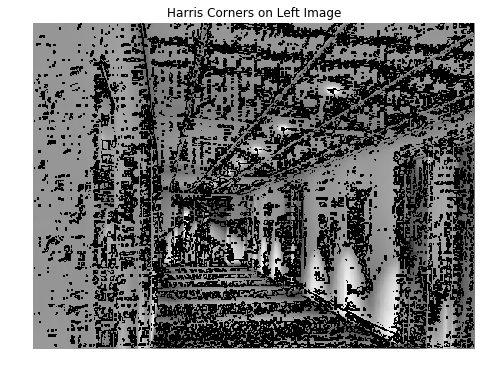

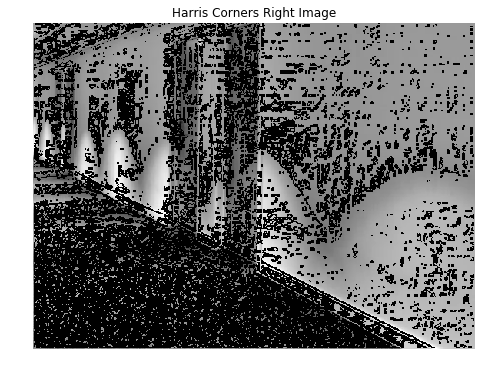

--Best X Trans--
198
--Best Y Trans--
129
--Best Error--
0.0
--Homography Matrix--
[[  1   0 198]
 [  0   1 129]
 [  0   0   1]]


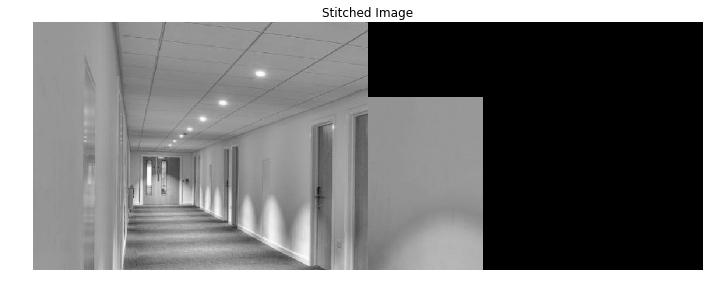

In [340]:
stitched_image = stitch_images(left_img_gray,right_img_gray)
plt.figure(figsize=(12,6))
plt.imshow(stitched_image, cmap='gray')
plt.axis('off')
plt.title('Stitched Image')
plt.show()

Finding Harris Corners...
Finding Harris Corners...


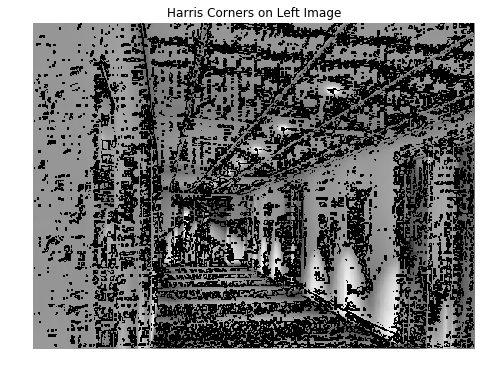

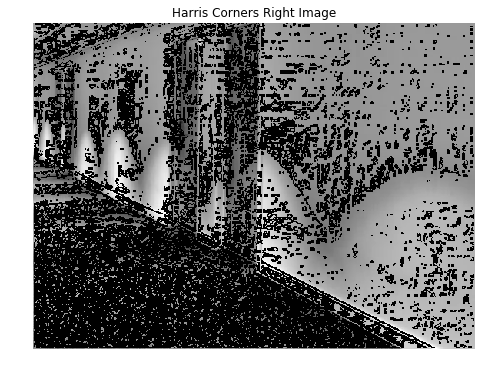

--Best X Trans--
308
--Best Y Trans--
197
--Best Error--
0.0
--Homography Matrix--
[[  1   0 308]
 [  0   1 197]
 [  0   0   1]]


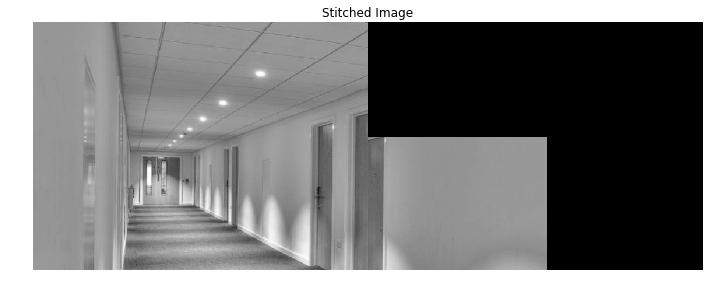

In [333]:
stitched_image = stitch_images(left_img_gray,right_img_gray)
plt.figure(figsize=(12,6))
plt.imshow(stitched_image, cmap='gray')
plt.axis('off')
plt.title('Stitched Image')
plt.show()

Finding Harris Corners...
Finding Harris Corners...


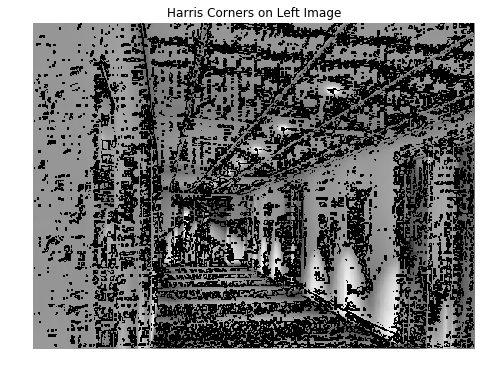

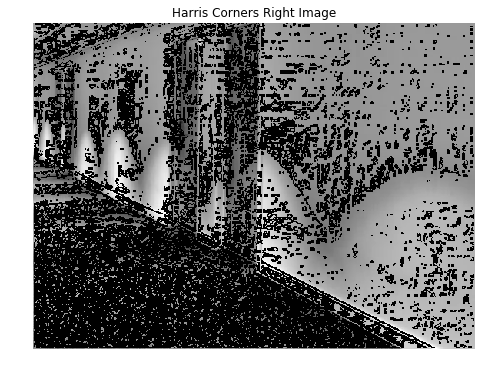

--Best X Trans--
52
--Best Y Trans--
114
--Best Error--
0.0
--Homography Matrix--
[[  1   0  52]
 [  0   1 114]
 [  0   0   1]]


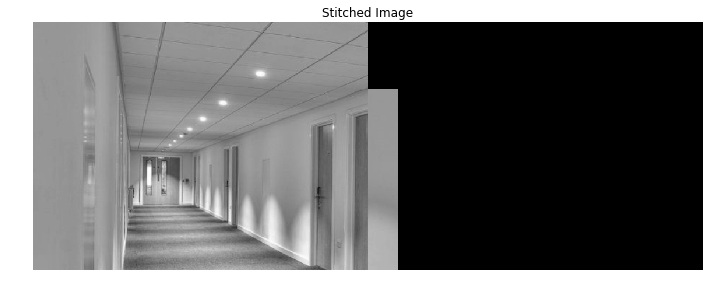

In [341]:
stitched_image = stitch_images(left_img_gray,right_img_gray)
plt.figure(figsize=(12,6))
plt.imshow(stitched_image, cmap='gray')
plt.axis('off')
plt.title('Stitched Image')
plt.show()

Finding Harris Corners...
Finding Harris Corners...


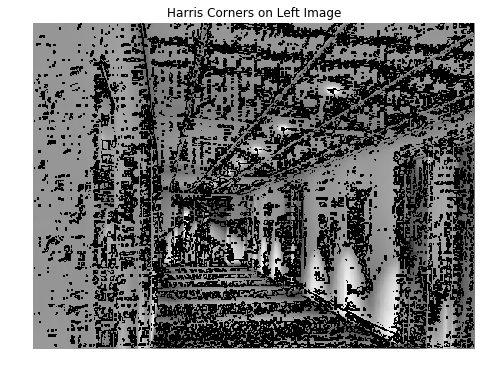

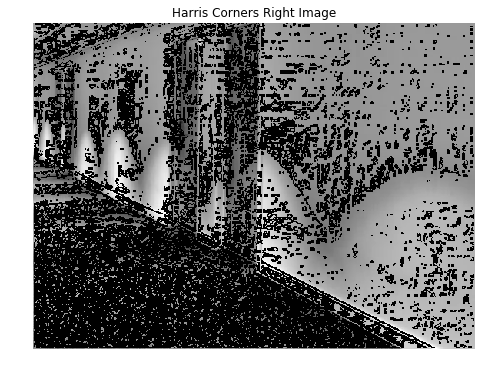

--Best X Trans--
397
--Best Y Trans--
179
--Best Error--
0.0
--Homography Matrix--
[[  1   0 397]
 [  0   1 179]
 [  0   0   1]]


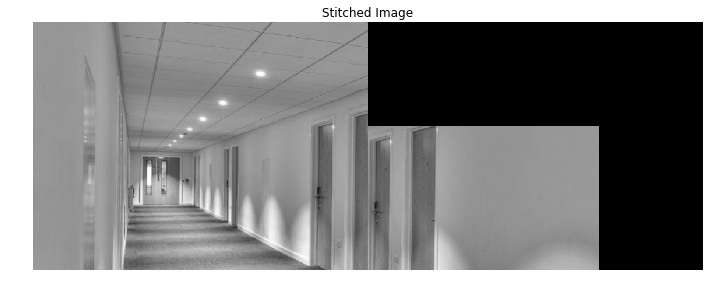

In [349]:
stitched_image = stitch_images(left_img_gray,right_img_gray)
plt.figure(figsize=(12,6))
plt.imshow(stitched_image, cmap='gray')
plt.axis('off')
plt.title('Stitched Image')
plt.show()

Finding Harris Corners...
Finding Harris Corners...


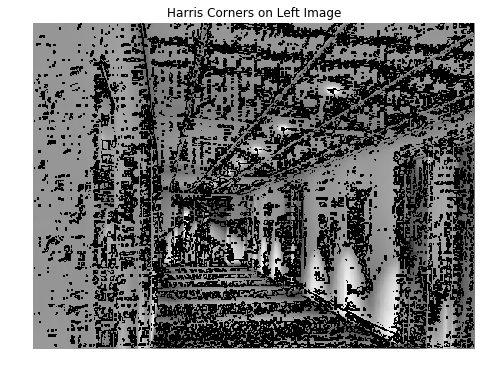

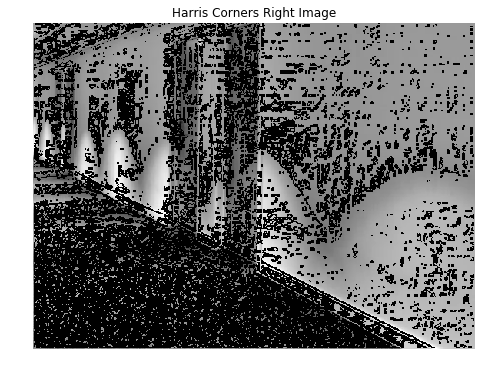

--Best X Trans--
125
--Best Y Trans--
145
--Best Error--
0.0
--Homography Matrix--
[[  1   0 125]
 [  0   1 145]
 [  0   0   1]]


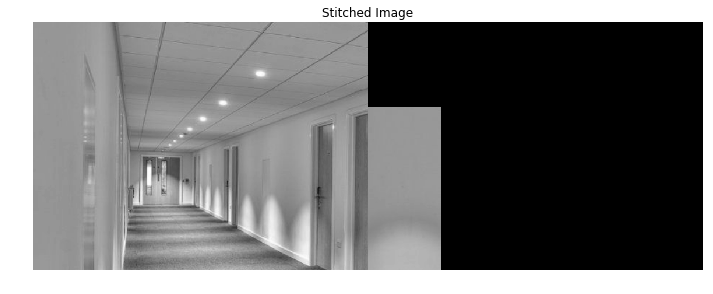

In [352]:
stitched_image = stitch_images(left_img_gray,right_img_gray)
plt.figure(figsize=(12,6))
plt.imshow(stitched_image, cmap='gray')
plt.axis('off')
plt.title('Stitched Image')
plt.show()

#### Comments

* This is a very naive strategy for Image Stitching because here we are trying to match the points by just considering the translation in x and y direction and once we get the best match (best_x translation, best_y translation), we assume that every point in the Image would have gone through the same transformation. Therefore the Image Stitching Output is not very accurate.
* Usually in order to compute homography matrix (H), four correspondences are required. And homography matrix (3x3 matrix) is computed by solving the system of linear equation obtained. Here since we are assuming that the points were only translated in either x or y direction therefore in order to compute H, I am substituting H(1,3) by best_x_trans and H(2,3) by best_y_trans and then perform perspective transformation using opencv helper function warpperspective. Refer here: https://docs.opencv.org/3.0-beta/modules/imgproc/doc/geometric_transformations.html?highlight=warp%20perspective#cv2.warpPerspective

**Remark.** Note that in this simplified problem setting, we assumed only translations along $x-$ and $y-$axes. However, in a real-world scenario, we can expect any affine transformation and/or viewpoint differences between the two images. This means we can no longer decide correspondences using only one pair of points. Can you think of a strategy that can be employed in such a scenario? 

#### Suggested Method

* In real world scenarios, in order to find correspondences between images, we can use feature descriptor based corner point detector like SIFT (although computationally slower) , SURF , FAST, Hessian Affine Region Detector etc. As such feature detectors are scale invariant, affine transformation invariant and also invariant to small viewpoint changes. And then perform nearest neighbor search like FLANN (Fast Approximate Nearest Neighbor Search) to find the matches between the points.